# Week II - Numerical solution of the 1D Schrödinger equation: the Numerov's method

For the full lecture on this topic, check out yesterday's lecture by Prof. Peressi on *The Numerov’s method for the 1D Schrödinger equation* (slides on Moodle) and Prof. Giannozzi lecture notes here https://www.fisica.uniud.it/~giannozz/Corsi/MQ/LectureNotes/mq.pdf (from which the following tutorial is inspired).


## Numerov’s method and the Schrödinger equation


As you have seen in the lecture of yesterday, the Numerov's method is useful to integrate second-order differential equations of the general form

$$\frac{d^2y}{dx^2} = g(x)y(x) + s(x).$$

The Schrödinger equation 
$$\frac{\hbar^2}{2m}\frac{d^2\psi}{dx^2} + V(x)\psi(x)  = E\psi(x)$$
falls indeed in this class

$g(x) = -\frac{2m}{\hbar^2}(E − V(x))$ and $s(x) = 0$

and can be solved by adopting the Numerov's approach.

### The algorithm
Let us take a one-dimensional (1D) finite box and divide it into $N$ small intervals of equal width $\Delta x$, hence defying a grid $x_i$ with $y_i=y(x_i)$.

The **Numerov's formula** allows obtaining $y_{n+1}$ starting from $y_n$ and $y_{n−1}$ and, recursively, the values of function over the entire box:

$$
y_{n+1} \left(1 + g_{n+1}\frac{(\Delta x)^2}{12}\right)=2y_{n}\left[1-5g_{n-1}\frac{(\Delta x)^2}{12}\right] - y_{n-1} \left[1+g_n\frac{(\Delta x)^2}{12}\right]+\left[s_{n+1} + 10s_n + s_{n-1}\right]\frac{(\Delta x)^2}{12}+ \mathcal{O}[(\Delta x)^6]
$$
where $g_n=g(x_n)$ and $s_n = s(x_n)$.

For the Schödinger equation we can write a more compact expression:
$$
y_{n+1}  = \frac{(12-10f_n)y_n-f_{n-1}y_{n-1}}{f_{n+1}}
$$
where $ f_n= 1 + g_n (\Delta x)^2 /12 $ and $g_n = 2m/\hbar^2(E-V(x_n))$.

> Note: the values of the function $y$ calculated at the first two points are needed to solve the equation (different from usual boundary conditions for second-order differential equations).


### The shooting method

The *shooting method* is very similar to the bisection procedure to identify the zero of a given function. We start by specifying an initial energy range $[E_{min},E_{max}]$ that must contain the unknown eigenvalue $E$. At the beginning, a tentative guess for E is set at $(E_{min}+E_{max})/2$. Then, the function is integrated starting from $x = 0$ and going towards positive values of $x$; during the process, the number of nodes  is counted by monitoring the changes of sign of the function. If the number of nodes is larger than the target one $n$, it means $E$ is too high. On the contrary, if the number of nodes is smaller than $n$, $E$ is too low. At each iteration, we set the lower half-interval $[E_{min},E_{max}=E]$, or the upper half-interval $[E_{min}=E,E_{max}]$, respectively; A new trial eigenvalue $E$ in the mid-point of the new interval, iterate the procedure. When the energy interval is smaller than a pre-determined threshold, we assume that convergence has been reached.

### 1D harmonic oscillator
In the following, we will see a Python implementation to solve the Schrödinger equation for the quantum harmonic oscillator. We will use the Numerov’s algorithm for integration, while eigenvalues of a pre-determined number n of nodes will be identified using the shooting method. For simplicity, dimensional units will be adopted. 

>The parity of the function determines the choice of the starting points for the recursion. For $n$ odd, the two first points can be chosen as $y_0 = 0$ and an arbitrary finite value for $y_1$. For $n$ even, $y_0$ is arbitrary and finite, $y_1$ is determined by Numerov’s formula by setting $f_1 = f_{-1}$ and $y_1 = y_{−1}$:
> $$y_1 = \frac{(12 − 10f_0)y_0}{2f_1}$$

In [1]:
# Loading Numpy module
import numpy as np

# Here we code our solver
def integrate_1D_harm_numerov(x_max,n_points,n_nodes,filename='res.txt'):
    '''
    This functions solves the one-dimensional Schroedinger equation
    for the harmonic oscillator by using the Numerov's method
    '''
    x = np.linspace(0,x_max, n_points+1,endpoint=True)
    dx =  float(x_max)/n_points 
    ddx12 = dx**2/12.0
    f = np.zeros(n_points+1,dtype=np.float64)
    y = np.zeros(n_points+1,dtype=np.float64)
    # Here below we define the potential for an harmonic oscillator
    v_pot = map(lambda xx: 0.5*xx**2, x)
    v_pot = np.array(list(v_pot),dtype=np.float64)

    #
    def solve_numerov(e):
        '''
        This function implements the Numerov's algorithm
        for a given input energy e
        '''
        f[0]=ddx12*(2.0*(v_pot[0]-e))
        cs_index=-1
        for i in range(1,n_points+1):
            f[i]=ddx12*2.0*(v_pot[i]-e)
            #
            #if f(i) is exactly zero the change of sign is not observed
            # the following line prevents missing a change of sign  
            if f[i] == 0.0:
                f[i]=1e-20

            if f[i]*f[i-1]<0:
                cs_index = i
                !
        if cs_index < 0: 
            print('WARNING: no classical turning point found.')

        # f = 1+g_n(dx^2/12) with g_n = (2.0*(e-v_pot[0]), but we used e-v and without the + 1
        f[:] = 1.0 - f[:]
        y[:] = 0.0

        # number of nodes in the semi-axis x>0
        h_n_nodes = int(n_nodes)//2

        if (2*h_n_nodes == n_nodes):
           # even number of nodes: wavefunction is even
           y[0] = 1.0
           # assume f(-1) = f(1)
           y[1] = 0.5*(12.0-10.0*f[0])*y[0]/f[1]
        else:
           # odd number of nodes: wavefunction is odd
           y[0] = 0.0
           y[1] = dx
        #
        # outward integration and count number of crossings
        #
        n_cross = 0
        for j in range(1,n_points):
            y[j+1]=((12.0-10.0*f[j])*y[j]-f[j-1]*y[j-1])/f[j+1]
            if y[j]*y[j+1]<0:
               n_cross+=1
        return n_cross, h_n_nodes,y
    
    # Here we initialize the bisection method
    e_up = np.max(v_pot)
    e_lw = np.min(v_pot)
    e_iter = 0
    data = []

    # Bisection loop
    while (np.abs(e_up-e_lw)>1e-10 and e_iter<1e6):
        e = 0.5 * (e_up+e_lw)
        n_cross,h_n_nodes,y = solve_numerov(e)
        if (n_cross > h_n_nodes):
            e_up = e
        else:
            e_lw = e
        #
        data.append([e_iter,n_cross,h_n_nodes,e])
        print('Iteration = {}, number of crossing = {} and nodes = {} for pos axis, energy = {}'.format(e_iter,n_cross,h_n_nodes,e))
        e_iter+=1
    
    # Writing to text file
    to_write = []
    for ii in range(n_points,0,-1):
        to_write.append([-x[ii], (-1)**n_nodes*y[ii],y[ii]**2])
    for ii in range(n_points+1):
        to_write.append([x[ii], y[ii],y[ii]**2])

    np.savetxt(filename,to_write)

    return data,y


-------------

### Numerical experiments 

Now let's run the code and visualize the results.
We start with the simple case of a nodeless wavefunction (ground state).


In [2]:
# x_max = 5, 1000+1 points, 0 nodes
_ = integrate_1D_harm_numerov(5,100,0,'zero_nodes.dat')

Iteration = 0, number of crossing = 3 and nodes = 0 for pos axis, energy = 6.25
Iteration = 1, number of crossing = 2 and nodes = 0 for pos axis, energy = 3.125
Iteration = 2, number of crossing = 1 and nodes = 0 for pos axis, energy = 1.5625
Iteration = 3, number of crossing = 1 and nodes = 0 for pos axis, energy = 0.78125
Iteration = 4, number of crossing = 0 and nodes = 0 for pos axis, energy = 0.390625
Iteration = 5, number of crossing = 1 and nodes = 0 for pos axis, energy = 0.5859375
Iteration = 6, number of crossing = 0 and nodes = 0 for pos axis, energy = 0.48828125
Iteration = 7, number of crossing = 1 and nodes = 0 for pos axis, energy = 0.537109375
Iteration = 8, number of crossing = 1 and nodes = 0 for pos axis, energy = 0.5126953125
Iteration = 9, number of crossing = 1 and nodes = 0 for pos axis, energy = 0.50048828125
Iteration = 10, number of crossing = 0 and nodes = 0 for pos axis, energy = 0.494384765625
Iteration = 11, number of crossing = 0 and nodes = 0 for pos axi

In a few iterations we have found the correct ground state total energy (i.e. $0.5$) and the right number of crossings, let's look at the wavefunction $\psi(x)$

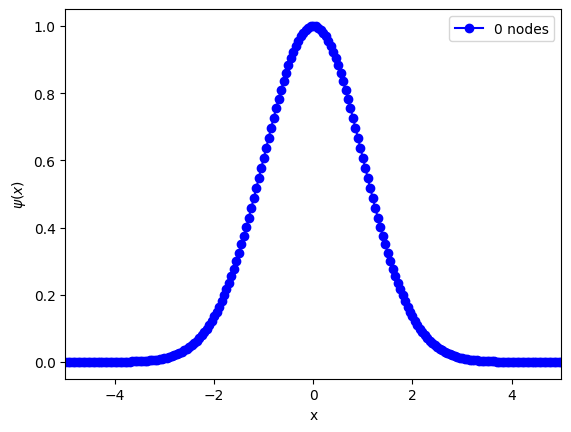

In [3]:
import matplotlib.pyplot as plt

data = np.loadtxt('zero_nodes.dat')
x = data[:,0]
y = data[:,1]

plt.xlabel('x')
plt.xlim([np.min(x),np.max(x)])

plt.ylabel('$\psi(x)$')
plt.plot(x,y,'-o', c='blue', label='0 nodes')
plt.legend()


Now we calculate the solution for 1 node, what do you expect to see?

In [4]:
_ = integrate_1D_harm_numerov(5,100,1,'one_node.dat')

Iteration = 0, number of crossing = 3 and nodes = 0 for pos axis, energy = 6.25
Iteration = 1, number of crossing = 1 and nodes = 0 for pos axis, energy = 3.125
Iteration = 2, number of crossing = 1 and nodes = 0 for pos axis, energy = 1.5625
Iteration = 3, number of crossing = 0 and nodes = 0 for pos axis, energy = 0.78125
Iteration = 4, number of crossing = 0 and nodes = 0 for pos axis, energy = 1.171875
Iteration = 5, number of crossing = 0 and nodes = 0 for pos axis, energy = 1.3671875
Iteration = 6, number of crossing = 0 and nodes = 0 for pos axis, energy = 1.46484375
Iteration = 7, number of crossing = 1 and nodes = 0 for pos axis, energy = 1.513671875
Iteration = 8, number of crossing = 0 and nodes = 0 for pos axis, energy = 1.4892578125
Iteration = 9, number of crossing = 1 and nodes = 0 for pos axis, energy = 1.50146484375
Iteration = 10, number of crossing = 0 and nodes = 0 for pos axis, energy = 1.495361328125
Iteration = 11, number of crossing = 0 and nodes = 0 for pos axi

The energy is correct ($1.5$)! Let's compare the nodeless and the one-node solutions: 

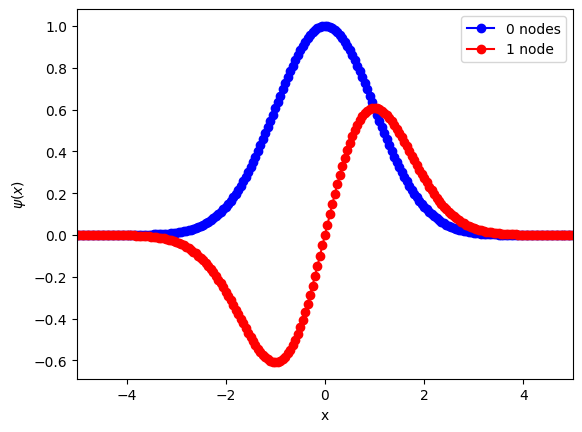

In [5]:
data_one_node = np.loadtxt('one_node.dat')
x_one_node = data_one_node[:,0]
y_one_node = data_one_node[:,1]

plt.xlabel('x')
plt.xlim([np.min(x),np.max(x)])

plt.ylabel('$\psi(x)$')
plt.plot(x,y,'-o', c='blue', label='0 nodes')
plt.plot(x_one_node,y_one_node,'-o', c='red', label='1 node')

plt.legend()


In [6]:
_ = integrate_1D_harm_numerov(5,100,5,'five_nodes.dat')

Iteration = 0, number of crossing = 3 and nodes = 2 for pos axis, energy = 6.25
Iteration = 1, number of crossing = 1 and nodes = 2 for pos axis, energy = 3.125
Iteration = 2, number of crossing = 2 and nodes = 2 for pos axis, energy = 4.6875
Iteration = 3, number of crossing = 2 and nodes = 2 for pos axis, energy = 5.46875
Iteration = 4, number of crossing = 3 and nodes = 2 for pos axis, energy = 5.859375
Iteration = 5, number of crossing = 3 and nodes = 2 for pos axis, energy = 5.6640625
Iteration = 6, number of crossing = 3 and nodes = 2 for pos axis, energy = 5.56640625
Iteration = 7, number of crossing = 3 and nodes = 2 for pos axis, energy = 5.517578125
Iteration = 8, number of crossing = 2 and nodes = 2 for pos axis, energy = 5.4931640625
Iteration = 9, number of crossing = 3 and nodes = 2 for pos axis, energy = 5.50537109375
Iteration = 10, number of crossing = 2 and nodes = 2 for pos axis, energy = 5.499267578125
Iteration = 11, number of crossing = 3 and nodes = 2 for pos axi

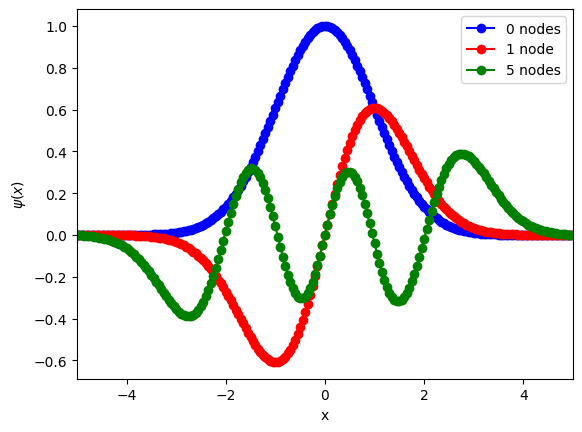

In [7]:
plt.xlabel('x')
plt.xlim([np.min(x),np.max(x)])
data_five_node = np.loadtxt('five_nodes.dat')
x_five_node = data_five_node[:,0]
y_five_node = data_five_node[:,1]
plt.ylabel('$\psi(x)$')
plt.plot(x,y,'-o', c='blue', label='0 nodes')
plt.plot(x_one_node,y_one_node,'-o', c='red', label='1 node')
plt.plot(x_five_node,y_five_node,'-o', c='green', label='5 nodes')
plt.legend()

Now let's try to increase the $x$ range, does the code still work?

In [8]:
_ = integrate_1D_harm_numerov(10,100,0,'large_x.dat')

Iteration = 0, number of crossing = 13 and nodes = 0 for pos axis, energy = 25.0
Iteration = 1, number of crossing = 7 and nodes = 0 for pos axis, energy = 12.5
Iteration = 2, number of crossing = 3 and nodes = 0 for pos axis, energy = 6.25
Iteration = 3, number of crossing = 2 and nodes = 0 for pos axis, energy = 3.125
Iteration = 4, number of crossing = 1 and nodes = 0 for pos axis, energy = 1.5625
Iteration = 5, number of crossing = 1 and nodes = 0 for pos axis, energy = 0.78125
Iteration = 6, number of crossing = 0 and nodes = 0 for pos axis, energy = 0.390625
Iteration = 7, number of crossing = 1 and nodes = 0 for pos axis, energy = 0.5859375
Iteration = 8, number of crossing = 0 and nodes = 0 for pos axis, energy = 0.48828125
Iteration = 9, number of crossing = 1 and nodes = 0 for pos axis, energy = 0.537109375
Iteration = 10, number of crossing = 1 and nodes = 0 for pos axis, energy = 0.5126953125
Iteration = 11, number of crossing = 1 and nodes = 0 for pos axis, energy = 0.5004

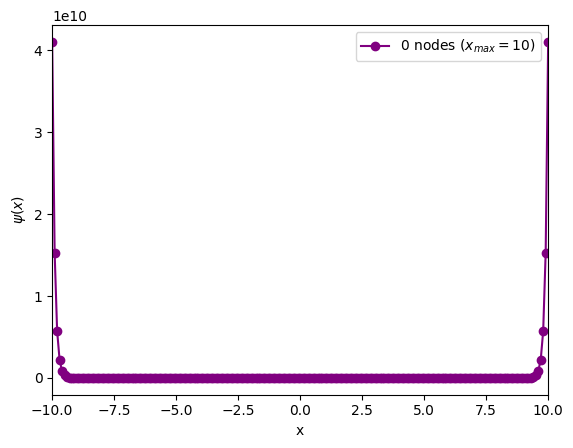

In [9]:
data_large_x = np.loadtxt('large_x.dat')
x_large_x = data_large_x[:,0]
y_large_x = data_large_x[:,1]

plt.xlabel('x')
plt.xlim([np.min(x_large_x),np.max(x_large_x)])

plt.ylabel('$\psi(x)$')
plt.plot(x_large_x,y_large_x,'-o', c='purple', label='0 nodes ($x_{max}=10$)')
plt.legend()


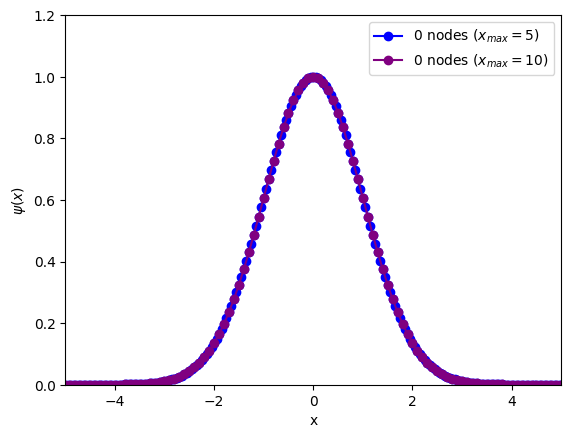

In [10]:
plt.xlabel('x')
plt.xlim([-5,5])
plt.ylim([0,1.2])
plt.ylabel('$\psi(x)$')
plt.plot(x,y,'-o', c='blue', label='0 nodes ($x_{max}=5$)')

plt.plot(x_large_x,y_large_x,'-o', c='purple', label='0 nodes ($x_{max}=10$)')
plt.legend()


>The two solutions are identical around the origin, but the code gives a spurious divergence for large values of $x$!

### Lab exercises (tomorrow)

* Study how results depend on the input parameters.
* Does the maximum number of nodes depend on the grid density?
* Implement a comparison between the quantum and classical probability densities.
* Try to implement an improved (but more complex) version of the algorithm that does not suffer from this drawback: Fortran codes for the basic (the one above) and improved Numerov's methods are already available on Moodle, start from there!
* Try to implement more complex potentials, such as the double-well 
$$V(x) = a ((x/b)^4 -2(x/b)^2 +1)$$

> Remember: except for simple potentials as those used in this tutorial (e.g. harmonic oscillator), in general analytical solutions are not available and one needs to resort to numerical integration methods.